# MIE 1624 Assignment 1: Sentiment Analysis

Starts by importing libraries that are used for data cleaning.

In [1]:
# !pip3 install pandas numpy --user
# !pip3 install --user
# !pip3 install HTMLParser --user
# !pip3 install nltk --user

import pandas as pd
import numpy as np
from html.parser import HTMLParser
from bs4 import BeautifulSoup
import unicodedata
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import matplotlib.pyplot as plt
from autocorrect import spell

%matplotlib inline

import sys
print(sys.version) # showing current python version

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/richard/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/richard/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/richard/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
3.5.2 (default, Nov 23 2017, 16:37:01) 
[GCC 5.4.0 20160609]


## Part 1: Data Cleaning

### 1.1 Reading Files

Reading in the generic tweet file and airline tweet file.

In [2]:
generic_tweets = pd.read_csv('generic_tweets.txt', parse_dates=['date'])
generic_tweets.head()

/home/richard/.local/lib/python3.5/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,class,id,date,query,user,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [3]:
airline_tweets = pd.read_csv('US_airline_tweets.csv')
airline_tweets.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


### 1.2 [Remove HTML tags and attributes](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and return HTML character codes (i.e., &...;) with an ASCII equivalent

When reading in the CSV files, the HTML tags and character codes are also read in. These symbols are noise to the model as they are not part of the natural language that the sentiment analysis should analyze.

By passing twitter text through BeautifulSoup html parser, the HTML character codes in text are automatically converted into ASCII equivalents, with the HTML tags removed.

This is done by defining a function called `parse` that takes a line of text and returns it after applying HTML parser to it.
The function is applied to each row of the dataframe by the `.apply()` method.

In [4]:
# defining function to be applied to all tweet
def parse(text):
    """
    remove html tags and attributes using beautifulSoup html.parser
    returns output as text
    """
    soup=BeautifulSoup(text,'html.parser')
    return soup.get_text()

In [5]:
# applying the parse function to all rows of the text column.
generic_tweets['text']=generic_tweets['text'].apply(parse)
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
# applying the parse function to all rows of the text column.
airline_tweets['text']=airline_tweets['text'].apply(parse)
airline_tweets.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."


### 1.3 [Normalize Unicode character with regular text](https://stackoverflow.com/a/3194567/10251025)

Some tweets might contain unicode equivalent characters as part of the text, and these character would add noise to the model. To remove this noise, `unicodedata.normalize` function is used to normalize unicode characters into regular alphabet.

In [7]:
def normalize(text):
    """
    normalizes unicode character to regular text
    Example: normalize('Cześć')='Czesc'
    """
    # read ascii characters using NFKD method, then decode back to string
    text=unicodedata.normalize('NFKD',text).encode('ascii', 'ignore').decode('utf-8')
    return text

In [8]:
# applying the normalize function to all rows of the text column.
generic_tweets['text']=generic_tweets['text'].apply(normalize)
airline_tweets['text']=airline_tweets['text'].apply(normalize)

### 1.4 [Removing URL](https://docs.python.org/2/library/re.html)

URL within the tweet cannot be processed as by the model, as it is not part of the natural language, and they will be a very low frequency feature in the model.. 

They are removed using the [regular expression operations](https://docs.python.org/3/library/re.html) inside the standard python library. 

The `re.sub` method searches within the string for anything that begins with **http** or **www** until a whitespace is seen, and replace all matches with `''`.

In [9]:
def remove_URL(text):
    """
    removes URL within a string by matching a pattern
    pattern: http or www until 1st white space seen
    """
    try:
        text = re.sub(r'http\S+', '', text) #match pattern http followed by any non whitespace followed by white space, replace with nothing
        text = re.sub(r'www\S+', '', text)#match pattern www followed by any non whitespace followed by white space, replace with nothing
    except:
        text = text
    return(text)

In [10]:
#removing URL from the tweets
generic_tweets['text']=generic_tweets['text'].apply(remove_URL)
airline_tweets['text']=airline_tweets['text'].apply(remove_URL)

### 1.5 Removing non letter and white spaces

Also using `re.sub` to remove none letters and white spaces. This is applied on only generic tweets here, as the airline mentions, identified by a leading @, is not yet stored. This will be applied to the airline tweets after airline mentions are stored.

Non-letters are removed by matching anything that is not in the a-z, A-Z, and white space set, and replacing all matches with a white space. 

In [11]:
def remove_nonletter(text):
    """
    matching anything that is not in the a-z, A-Z and white space set, replace with white space
    """
    try:
        text=re.sub(r'[^a-zA-Z ]+', ' ', text)
    except:
        text=text
    return text

All texts are further cleaned by setting all of the text to lower case, and removing extra white space.

In [12]:
def remove_ws(text):
    """
    Removing extra whitespace, make all text lower case, and remove trailing and leading white spaces
    """
    try:
        text=re.sub(r'\s+', ' ', text) #removes extra white space, strip leading and trailing white space
        text=text.lower() #make all text lower case
    except:
        text=text
    return text

In [13]:
#removing white space and non letter from generic_tweets dataframe
generic_tweets['text']=generic_tweets['text'].apply(remove_nonletter)
generic_tweets['text']=generic_tweets['text'].apply(remove_ws)

In [14]:
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,switchfoot a that s a bummer you shoulda got ...
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,is upset that he can t update his facebook by ...
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,kenichan i dived many times for the ball mana...
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,nationwideclass no it s not behaving at all i...


### 1.6 [Storing airline mentions](https://stackoverflow.com/a/43958095/10251025)

In [15]:
#removing white space from airline_tweets dataframe
airline_tweets['text']=airline_tweets['text'].apply(remove_ws)

Using the `re.findall` function, any part of the string that begins with @ and ends with a white space is found and converted into a list. 

Since there might be multiple mentions within one tweet and user mentions that are not the airlines, each mentioned found is compared against a dictionary to output the actual airline names seen. 

This dictionary is made by looking at what all the unique mentions found in all the tweets to identify which airlines are mentioned. 

This method would only return the first airline mentions seen within a tweet. In tweets where multiple airlines are mentioned, the mentions after the first will be ignored. However, this would not have a significant impact on the model as thre are very few tweets that mentioned multiple airlines.

In [16]:
#define a dictionary of airline names. This is to find the actual airline mention within a tweet
airlines={'@virginamerica':'virginamerica', 
          '@united':'united', 
          '@southwestair':'southwestair', 
          '@jetblue':'jetblue',
          '@usairways':'usairways', 
          '@americanair':'americanair', 
          '@deltaassist':'deltaassist'}

def find_mentions(text):
    global airlines
    text=re.findall(r'@\S+',text)
    if len(text)>=1:
        for i in text:
            for j in airlines:
                if j in i:return airlines[j]

In [17]:
# finding mentions in airline tweets, and storing it in a column called airline
airline_tweets['airline']=airline_tweets['text'].apply(find_mentions)

#removing non_letters from airline tweets
airline_tweets['text']=airline_tweets['text'].apply(remove_nonletter)
airline_tweets['airline'].unique()

array(['virginamerica', 'united', 'southwestair', 'jetblue', None,
       'usairways', 'americanair', 'deltaassist'], dtype=object)

In [18]:
airline_tweets.head()

,id,sentiment,negative_reason,user,retweet_count,text,airline
0,5.703010e+17,positive,NaN,jnardino,0,virginamerica plus you ve added commercials t...,virginamerica
1,5.703010e+17,negative,Bad Flight,jnardino,0,virginamerica it s really aggressive to blast...,virginamerica
2,5.703010e+17,negative,Can't Tell,jnardino,0,virginamerica and it s a really big bad thing...,virginamerica
3,5.703010e+17,negative,Can't Tell,jnardino,0,virginamerica seriously would pay a flight ...,virginamerica
4,5.703010e+17,positive,NaN,cjmcginnis,0,virginamerica yes nearly every time i fly vx...,virginamerica


There was one tweet that had null value for its airline mention applying the `find_mentions` function. This tweet is dropped because this is JetBlue replying to a user. This is is not what this sentiment analysis is analyzing, thus is removed.

In [19]:
# checking which airline showed up as null
airline_tweets[airline_tweets['airline'].isnull()]

,id,sentiment,negative_reason,user,retweet_count,text,airline
6184,5.686020e+17,positive,NaN,JetBlue,3,ninadavuluri we think it s a treat to have yo...,None


In [20]:
# removing the tweet where Jetblue replied to a user
airline_tweets=airline_tweets.dropna(subset=['airline'])
airline_tweets[airline_tweets['airline'].isnull()]

,id,sentiment,negative_reason,user,retweet_count,text,airline


### 1.8 Remove stop words

Using stop word list from the natural language tool kit to remove words that are part of the common speech. These are not keywords that carry unique meaning, thus should be removed from the tweets so that the model can analyze only the keywords within the tweet.

In [21]:
# getting ntlk stop word list into dataframe
stop_words_ntlk=pd.DataFrame(data=list(stopwords.words('english')), columns=['word'])
stop_words_combined=stop_words_ntlk

In [22]:
#removing stop words for generic tweets
generic_tweets['text']=generic_tweets['text'].apply(lambda x : x.split())
generic_tweets['text']=generic_tweets['text'].apply(lambda y : [word for word in y if word not in stop_words_combined.values])
generic_tweets.head()

,class,id,date,query,user,text
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"[switchfoot, bummer, shoulda, got, david, carr..."
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,"[upset, update, facebook, texting, might, cry,..."
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,"[kenichan, dived, many, times, ball, managed, ..."
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,"[whole, body, feels, itchy, like, fire]"
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"[nationwideclass, behaving, mad, see]"


In [23]:
# removing stop words for airline tweets
airline_tweets['text']=airline_tweets['text'].apply(lambda x : x.split())
airline_tweets['text']=airline_tweets['text'].apply(lambda y : [word for word in y if word not in stop_words_combined.values])
airline_tweets.head()

,id,sentiment,negative_reason,user,retweet_count,text,airline
0,5.703010e+17,positive,NaN,jnardino,0,"[virginamerica, plus, added, commercials, expe...",virginamerica
1,5.703010e+17,negative,Bad Flight,jnardino,0,"[virginamerica, really, aggressive, blast, obn...",virginamerica
2,5.703010e+17,negative,Can't Tell,jnardino,0,"[virginamerica, really, big, bad, thing]",virginamerica
3,5.703010e+17,negative,Can't Tell,jnardino,0,"[virginamerica, seriously, would, pay, flight,...",virginamerica
4,5.703010e+17,positive,NaN,cjmcginnis,0,"[virginamerica, yes, nearly, every, time, fly,...",virginamerica


### 1.9 Lemmatising

Lemmatising each words within a tweet to return each word to the base or dictionay form of a word. This condenses variations of one word into its base form. 

Lemmatising is chosen over stemming as it is usually more precise than Stemming. Stemming is a crude process that removes the end of the word to attempt to return the word to its base form, where as Lemmatization uses a vocabulary and morphological analysis of the word to return it to its base form. Lemmatization is more computationally expensive than stemming, however, given the dataset is small in this analysis, the computation cost is negligable.

In [24]:
# construct lemmatising function

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatising (text):
    x = [lemmatizer.lemmatize(word) for word in text]
    return x

In [25]:
#applying lemmatization to each dataset
generic_tweets['text']=generic_tweets.text.apply(lemmatising)
airline_tweets['text']=airline_tweets.text.apply(lemmatising)

## Part 2: Exploratory Analysis

### 2.1 Extract airline mentions
Airline mentions were extracted in Step 1.6, because the data cleaning process would have removed the airline mentions identifier. 
Below is a tablulated form of the number of mentions of each airline after extraction.

In [26]:
print(airline_tweets['airline'].value_counts(normalize=True));print('\n')
print(airline_tweets['airline'].value_counts());print('\n')
print('Total Tweet Count: '+ str(airline_tweets['airline'].value_counts().values.sum()))

united           0.270711
usairways        0.219411
americanair      0.198960
southwestair     0.152253
jetblue          0.129636
virginamerica    0.028856
deltaassist      0.000173
Name: airline, dtype: float64


united           3124
usairways        2532
americanair      2296
southwestair     1757
jetblue          1496
virginamerica     333
deltaassist         2
Name: airline, dtype: int64


Total Tweet Count: 11540


In [27]:
#showing all airline tweets that sentiment column has the value 'negative' and group by the airline column ...
#...showing only sentiment column, and count them
tmp=airline_tweets[airline_tweets.sentiment=='negative'].groupby('airline').sentiment.agg(['count'])
tmp.columns=['negative']
tmp2=airline_tweets[airline_tweets.sentiment=='positive'].groupby('airline').sentiment.agg(['count'])
tmp2.columns=['positive']
tmp=tmp.join(tmp2).fillna(0)
tmp['%neg']=tmp.apply(lambda x: round(int(x['negative'])/(int(x['positive'])+int(x['negative'])),3)*100,axis=1)
tmp['%pos']=tmp.apply(lambda x: round(int(x['positive'])/(int(x['positive'])+int(x['negative'])),3)*100,axis=1)
tmp['total']=tmp.apply(lambda x: (int(x['positive'])+int(x['negative'])),axis=1)
tmp=tmp.sort_values(by=['total'], ascending=False)
tmp2=None
tmp

,negative,positive,%neg,%pos,total
airline,,,,,
united,2632,492.0,84.3,15.7,3124
usairways,2263,269.0,89.4,10.6,2532
americanair,1960,336.0,85.4,14.6,2296
southwestair,1187,570.0,67.6,32.4,1757
jetblue,953,543.0,63.7,36.3,1496
virginamerica,181,152.0,54.4,45.6,333
deltaassist,2,0.0,100.0,0.0,2


**Observation**

There are total of around 11540 tweets that mentioned an airline. 

Of these tweets, [United](https://twitter.com/united?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor) airline has the most mentions at 3124 (27.07%) mentions, and [Delta Assist](https://twitter.com/deltaassist?lang=en) (which refers to delta airlines) has the least mentions at 2, which is 0.02% of total number of mentions. 

[US airways](https://twitter.com/USAirways?lang=en) and [American Air](https://twitter.com/AmericanAir?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor) has similar number of mentions, at 2532 (21.94%) and 2296 (19.90%) respectively.

United, US Airways and American air all recieved similar percentages of negative comments, around 84~89% range, and virginamerica recieved the most percentage of positive comments, at 45.6%.

### 2.2 Dataset Visualization

#### Plot for Generic Tweets

In [28]:
# visualizing how length distribution of the tweets
generic_tweets['length'] = generic_tweets['text'].apply(len)
generic_tweets.head()

,class,id,date,query,user,text,length
0,0,1467810369,2009-04-06 22:19:45,NO_QUERY,_TheSpecialOne_,"[switchfoot, bummer, shoulda, got, david, carr...",8
1,0,1467810672,2009-04-06 22:19:49,NO_QUERY,scotthamilton,"[upset, update, facebook, texting, might, cry,...",11
2,0,1467810917,2009-04-06 22:19:53,NO_QUERY,mattycus,"[kenichan, dived, many, time, ball, managed, s...",10
3,0,1467811184,2009-04-06 22:19:57,NO_QUERY,ElleCTF,"[whole, body, feel, itchy, like, fire]",6
4,0,1467811193,2009-04-06 22:19:57,NO_QUERY,Karoli,"[nationwideclass, behaving, mad, see]",4


The tweet length distirbution between each sentiment are similar in shape. This means that length would not be a good feature to identify if a tweet is positive or negative.

Text(-0.04, 0.5, 'Frequency')

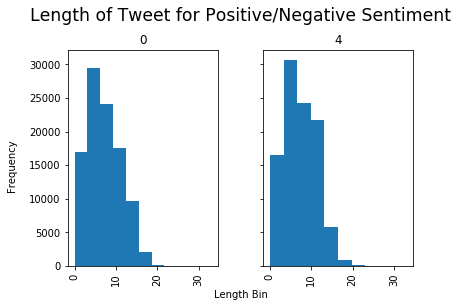

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
generic_tweets.hist('length', by='class', ax=axes)
plt.suptitle('Length of Tweet for Positive/Negative Sentiment', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'Length Bin', ha='center')
fig.text(-0.04, 0.5, 'Frequency', va='center', rotation='vertical')

The number of positive sentiment and negative sentiment is the same in the dataset, this means that the dataset is a balanced one. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb19a19bba8>]],
      dtype=object)

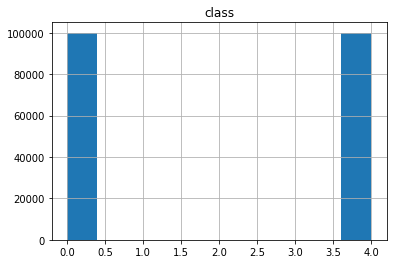

In [30]:
# visualizing how tweets are there for each sentiment
generic_tweets.hist('class')

#### Plot for US Airline Tweets

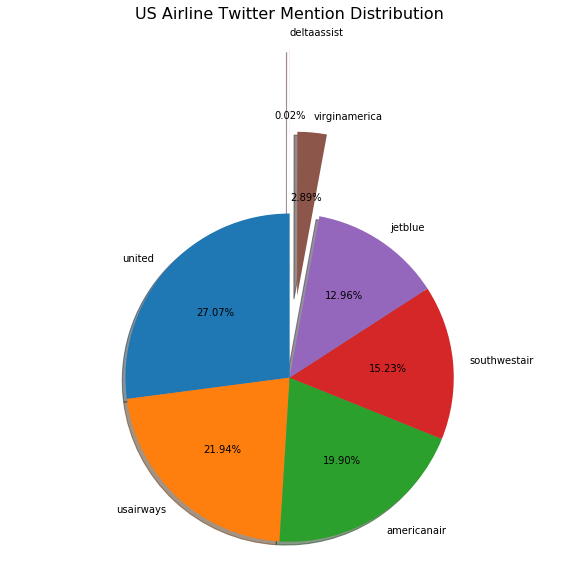

In [31]:
labels = list(airline_tweets['airline'].value_counts().keys())
sizes = list(airline_tweets['airline'].value_counts().values)
explode = (0, 0, 0, 0, 0, 0.5, 1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', startangle=90, shadow=True)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig = plt.gcf()
fig.set_size_inches(10,10) # or (4,4) or (5,5) or whatever
plt.title('US Airline Twitter Mention Distribution', fontsize=16)
plt.show()

This stacked bar chart shows that most of the tweets for all the airline have negative sentiments.

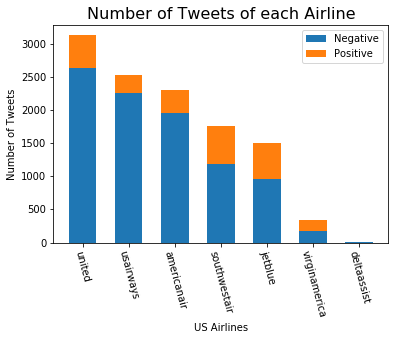

In [32]:
labels = list(tmp.index.values)

neg = (list(tmp.negative.values))
pos = (list(tmp.positive.values))
ind = np.arange(len(labels))    # the x locations for the groups
width = 0.6     # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, neg, width)
p2 = plt.bar(ind, pos, width, bottom=neg)

plt.ylabel('Number of Tweets')
plt.xlabel('US Airlines')
plt.title('Number of Tweets of each Airline', fontsize=16)
plt.xticks(ind, labels)
# plt.yticks(np.arange(0, 81, 10))
plt.xticks(rotation=-75)
plt.legend((p1[0], p2[0]), ('Negative', 'Positive'))

plt.show()

## 3. Model Preparation

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import metrics

Defining a function for plotting a confusiong matrix

In [34]:
# function for plotting confusion matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, fs=(12,12),font_size=12):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=fs);
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=font_size)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=font_size-2)
    plt.xlabel('Predicted label', fontsize=font_size-2)
    plt.tight_layout()

Here a function that joins each tweet back into one string from its list form. This is because the countVectorizer from SKLearn takes in a string.

In [35]:
#defining a function that put back the split tweet text back into a string for countvectorizer
def make_str(text):
    """
    this joins the previously split text back into a string for inputting the text into count vectorizer
    """
    y=''
    for x in text:
        y= y+' '+x
    return y

**Model Preparation Technique**

The model is prepared using the bag of word technique. Using the frequency of each word that appear in each tweet as the feature of the tweet. 

An alternative method is to convert the tweet into a corpus score. This method was tried and was found to yield only about 50% accuracy, this is likely because of the corpus dictionary does not contain a exhaustive list of words. Visualization of the corpus score histogram shows that most tweets have a corpus score of 0, which means that most of the words each tweet might not be in the corpus vocabulary. Therefore, corpus score is a poor method of measuring the feature of the tweet. 

**Applying Bag of Words**

Count vectorizer and TFIDF transformer is used to apply the bag of words technique. 

- Count vectorizer converts the tweet texts into a matrix of text tokens.

- TFIDF transformer is a combination of TF transformer and IDF transformer. The TF transformer finds the frequency of each word that exists within the each tweet string. IDF transformer normalizes this frequency so that words that might have higher frequency because the tweet is longer gets the same weighting as if it was in a shorter tweet.

In [36]:
# make all the tweet text back into a single string, and assign posivie/negative sentiment to class 4/0
generic_tweets_vec=generic_tweets.copy()
generic_tweets_vec.text=generic_tweets_vec.text.apply(make_str)

generic_tweets_vec['sentiment'] = np.where(generic_tweets_vec['class']==4, 'positive', 'negative')

In [37]:
#constructing count vectorizer and tfidftransformer

cv=CountVectorizer(ngram_range=(1,3))
tfidf = TfidfTransformer()

#transform tweets into N-gram frequencies
generic_bag=cv.fit_transform(generic_tweets_vec.text)
generic_trans = tfidf.fit_transform(generic_bag)

generic_trans.shape

(200000, 1914113)

The dataset is split into 70% training and 30% testing data using the `sklearn.model_selection train_test_split()` function

In [38]:
X=generic_trans
Y=generic_tweets_vec['sentiment']

#splitting the dataset into training and testing set.
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3, random_state=101)

Construct an instance of Logistic Regression, and fit the training data to it with the default settings. See bonus section for how the hyperparameter C=5 was choosen.

In [39]:
#construct an instance of logistic regression function, and fit the generic tweets training model to it. 
model=LogisticRegression(C=5)
model.fit(X_train,Y_train);

/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [40]:
#predict the testing model
y_pred=model.predict(X_test)

Here the accuracy of the model is cross validated to show that the model is not over fitted with C=5

In [41]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, Y, cv=10)

/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross Validation Accuracy: 0.771 (+/- 0.016)
Prediction Accuracy Score: 77.4%


              precision    recall  f1-score   support

    negative       0.79      0.74      0.77     30109
    positive       0.76      0.80      0.78     29891

   micro avg       0.77      0.77      0.77     60000
   macro avg       0.77      0.77      0.77     60000
weighted avg       0.77      0.77      0.77     60000



<Figure size 432x288 with 0 Axes>

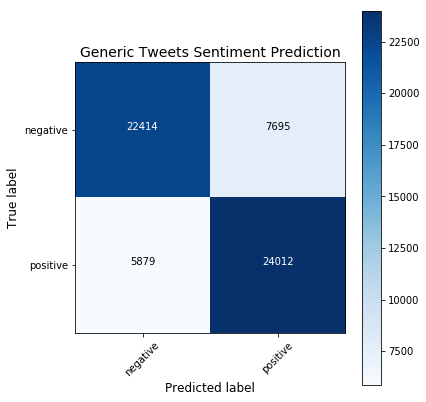

In [42]:
#showing the result of the testing set
print("Cross Validation Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))
print ('Prediction Accuracy Score: ' + str(round(accuracy_score(Y_test, y_pred),3)*100) +'%')
print ('\n')
print(classification_report(Y_test,y_pred))

ticklabel=generic_tweets_vec['sentiment'].unique()
cm=metrics.confusion_matrix(Y_test, y_pred, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Generic Tweets Sentiment Prediction', fs=(6,6), font_size=14)

## 4. Model Implementation

### 4.1 Eavluating Airline Model with Generic Tweets Model

In [43]:
airline_tweets_vec=airline_tweets.copy()
airline_tweets_vec.text=airline_tweets_vec.text.apply(make_str)

In [44]:
#transforming the data set into N-grams frequency features

airline_bag=cv.transform(airline_tweets_vec.text)
airline_trans = tfidf.transform(airline_bag)

airline_trans.shape

(11540, 1914113)

In [45]:
#apply model trained using generic tweets dataset to airline tweets
y_pred_air=model.predict(airline_trans)

Prediction Accuracy Score: 80.9%
              precision    recall  f1-score   support

    negative       0.96      0.80      0.87      9178
    positive       0.52      0.86      0.65      2362

   micro avg       0.81      0.81      0.81     11540
   macro avg       0.74      0.83      0.76     11540
weighted avg       0.87      0.81      0.82     11540



<Figure size 432x288 with 0 Axes>

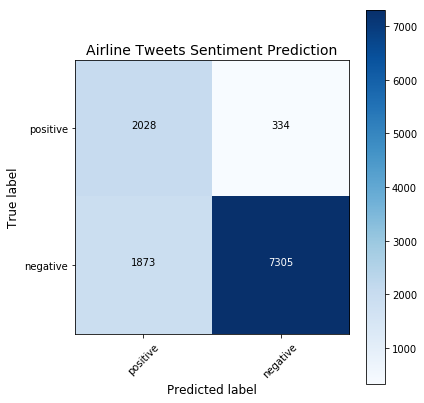

In [46]:
# presenting the result of the model predictions
ticklabel=airline_tweets_vec.sentiment.unique()
cm=metrics.confusion_matrix(airline_tweets_vec.sentiment, y_pred_air, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Airline Tweets Sentiment Prediction', fs=(6,6), font_size=14)
print ('Prediction Accuracy Score: '+str((round(accuracy_score(airline_tweets_vec.sentiment, y_pred_air),3))*100)+'%')
print(classification_report(airline_tweets_vec.sentiment, y_pred_air))

### Bonus: N-Grams Feature Tuning for Sentiment Prediction Model

N-Grams is basically a set of N adjacent words within a string. For example, for a string "This sentiment analysis predicts emotions" and N = 2, the N-grams are:

```
['This sentiment', 'sentiment analysis', 'analysis predicts', 'predicts emotions']

```
N=1 is unigram, N=2 is bigram, N=3 is trigram. 

When tokenizing the tweets into bag of words, the default option is a unigram. However, additional bag of words can be generated by stating the range of desired N-Grams. This means that the accuracy of the model could be improve by determining what is the optimal N-gram option.

The for loop below goes through the various N-grams combinations, where (1,1) means unigram feature, (1,2) means unigram and bigram features, (1,3) means unigram, bigrams and trigrams and so forth.

In [47]:
n_grams=[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]

for x in n_grams:
    cv_1=CountVectorizer(ngram_range=(x))
    tfidf = TfidfTransformer()

    generic_tweets_n_grams=generic_tweets.copy()
    generic_tweets_n_grams.text=generic_tweets_n_grams.text.apply(make_str)
    generic_tweets_n_grams['sentiment'] = np.where(generic_tweets_n_grams['class']==4, 'positive', 'negative')
    generic_bag=cv_1.fit_transform(generic_tweets_n_grams.text)
    generic_trans = tfidf.fit_transform(generic_bag)
    X=generic_trans
    Y=generic_tweets_n_grams['sentiment']
    X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3, random_state=101)

    model_ngrams=LogisticRegression(random_state=0)
    model_ngrams.fit(X_train,Y_train)
    y_pred=model_ngrams.predict(X_test)

    print ('Generic Tweets Test Set Accuracy: ' + str(round(accuracy_score(Y_test, y_pred),3))+' x:' +str(x))

    airline_tweets_n_grams=airline_tweets.copy()
    airline_tweets_n_grams.text=airline_tweets_n_grams.text.apply(make_str)

    airline_bag=cv_1.transform(airline_tweets_n_grams.text)
    airline_trans = tfidf.transform(airline_bag)

    y_pred_air_n_grams=model_ngrams.predict(airline_trans)
    print ('Airline Tweet Prediction Accuracy: ' + str(round(accuracy_score(airline_tweets_vec.sentiment, y_pred_air_n_grams),3))+' x:' +str(x))
    print ('\n')

/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Generic Tweets Test Set Accuracy: 0.768 x:(1, 1)
Airline Tweet Prediction Accuracy: 0.773 x:(1, 1)


Generic Tweets Test Set Accuracy: 0.771 x:(1, 2)
Airline Tweet Prediction Accuracy: 0.789 x:(1, 2)


Generic Tweets Test Set Accuracy: 0.768 x:(1, 3)
Airline Tweet Prediction Accuracy: 0.794 x:(1, 3)


Generic Tweets Test Set Accuracy: 0.681 x:(2, 2)
Airline Tweet Prediction Accuracy: 0.592 x:(2, 2)


Generic Tweets Test Set Accuracy: 0.678 x:(2, 3)
Airline Tweet Prediction Accuracy: 0.59 x:(2, 3)


Generic Tweets Test Set Accuracy: 0.555 x:(3, 3)
Airline Tweet Prediction Accuracy: 0.243 x:(3, 3)




As seen through the combination of N-grams input to the model, n-grams with the range of (1,3) gives the highest accuracy on predicting the airline tweets. Thus N-gram of (1,3) is choosen for the countvectorizer.

### Bonus: Sentiment Analysis Logistic Regression Hyper Parameter Tuning: C parameter

C parameter is the inverse of regularization strength in the logistic regression model. Regularization strength is a penalty value applied to the parameter magnitudes in order to reduce overfitting the logistic regression function. This is important whan there is lots of features to the dataset, but not enough data, which would result in the the regression model fit the training set very well, but performs poorly on any future testing sets. 

This model is not overfitted because the airline prediction accuracy is around 79.4%. However, the model accuracy could be further improved by seeing how the accuracy changes with different C parametes.

In [48]:
C_param_range=[4,5,6,7,8,9,10]
generic_acc=[]
airline_acc=[]
for x in C_param_range:
    cv_2=CountVectorizer(ngram_range=(1,3))
    tfidf = TfidfTransformer()

    generic_tweets_c_params=generic_tweets.copy()
    generic_tweets_c_params.text=generic_tweets_c_params.text.apply(make_str)
    generic_tweets_c_params['sentiment'] = np.where(generic_tweets_c_params['class']==4, 'positive', 'negative')
    generic_bag=cv_2.fit_transform(generic_tweets_c_params.text)
    generic_trans = tfidf.fit_transform(generic_bag)
    
    X=generic_trans
    Y=generic_tweets_c_params['sentiment']
    X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.3, random_state=101)

    model_c_params=LogisticRegression(C=x, random_state=0)
    model_c_params.fit(X_train,Y_train)
    y_pred=model_c_params.predict(X_test)
    
    print ('Generic Tweets Test Set Accuracy: ' + str(round(accuracy_score(Y_test, y_pred),3))+' C_param:' +str(x))
    generic_acc.append(round(accuracy_score(Y_test, y_pred),3))
    
    airline_tweets_c_params=airline_tweets.copy()
    airline_tweets_c_params.text=airline_tweets_c_params.text.apply(make_str)

    airline_bag=cv_2.transform(airline_tweets_c_params.text)
    airline_trans = tfidf.transform(airline_bag)

    y_pred_air_c_params=model_c_params.predict(airline_trans)
    
    print ('Airline Tweet Prediction Accuracy: ' + str(round(accuracy_score(airline_tweets_vec.sentiment, y_pred_air_c_params),3))+' C_param:' +str(x))
    airline_acc.append(round(accuracy_score(airline_tweets_vec.sentiment, y_pred_air_c_params),3))
    
    print ('\n')

/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Generic Tweets Test Set Accuracy: 0.774 C_param:4
Airline Tweet Prediction Accuracy: 0.809 C_param:4


Generic Tweets Test Set Accuracy: 0.774 C_param:5
Airline Tweet Prediction Accuracy: 0.809 C_param:5


Generic Tweets Test Set Accuracy: 0.774 C_param:6
Airline Tweet Prediction Accuracy: 0.808 C_param:6


Generic Tweets Test Set Accuracy: 0.775 C_param:7
Airline Tweet Prediction Accuracy: 0.808 C_param:7


Generic Tweets Test Set Accuracy: 0.775 C_param:8
Airline Tweet Prediction Accuracy: 0.809 C_param:8


Generic Tweets Test Set Accuracy: 0.775 C_param:9
Airline Tweet Prediction Accuracy: 0.809 C_param:9


Generic Tweets Test Set Accuracy: 0.775 C_param:10
Airline Tweet Prediction Accuracy: 0.809 C_param:10




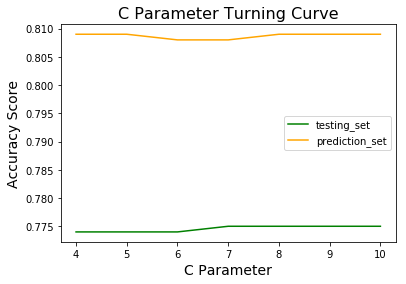

In [49]:
test_set,=plt.plot(C_param_range, generic_acc, color='green', label='testing_set')
prediction_set,=plt.plot(C_param_range, airline_acc, color='orange', label='prediction_set')
plt.title('C Parameter Turning Curve', fontsize=16)
plt.xlabel('C Parameter',fontsize=14)
plt.ylabel('Accuracy Score',fontsize=14)
plt.legend()
plt.show()

C parameter of around 10 gives the highest accuracy score for both the prediction set and the testingset. Thus C=10 is choosen for the model.

### 4.2 Airline Multi-Class logistic regression model

In [50]:
# saving all negative sentiment airline tweets to a dataframe
airline_tweets_neg=airline_tweets_vec[airline_tweets_vec.sentiment=='negative']

In [51]:
airline_tweets_neg.negative_reason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negative_reason, dtype: int64

Given negative reason categories *Damaged Luggage* and *longlines* only account for 0.8% and 2% of total negative reasons, only have 74 and 178 samples, the model is not likely to correctly predict these two categories. Thus *Damaged Luggage* is grouped into *Lost luggage* and is renamed into *Luggage Issues*. Longlines is grouped into *Customer Service Issue*

Furthermore, flight attendant complaints is very similar to customer service issue, thus is also grouped into it.

In [52]:
#consolidating damaged and lost luggage into luggage issues, longlines and flight attendant complaints into customer service
airline_tweets_neg['negative_reason']=airline_tweets_neg['negative_reason'].apply(lambda x : 'Customer Service Issue' if (x == "longlines") else x);
airline_tweets_neg['negative_reason']=airline_tweets_neg['negative_reason'].apply(lambda x : 'Luggage Issue' if (x=='Damaged Luggage' or x == 'Lost Luggage') else x);
airline_tweets_neg['negative_reason']=airline_tweets_neg['negative_reason'].apply(lambda x : 'Customer Service Issue' if (x == "Flight Attendant Complaints") else x);

airline_tweets_neg.negative_reason.value_counts(normalize=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Customer Service Issue     0.388865
Late Flight                0.181412
Can't Tell                 0.129658
Cancelled Flight           0.092286
Luggage Issue              0.086947
Bad Flight                 0.063195
Flight Booking Problems    0.057638
Name: negative_reason, dtype: float64

In [53]:
# transform airline tweets into unigram features.
cv_multi=CountVectorizer(ngram_range=(1,1))
tfidf_multi = TfidfTransformer()

airline_tweets_neg_text=cv_multi.fit_transform(airline_tweets_neg.text)
airline_neg_trans = tfidf_multi.fit_transform(airline_tweets_neg_text)

airline_neg_trans.shape

(9178, 8285)

In [54]:
#splitting the dataset into testing and training data
X_multi=airline_neg_trans
Y_multi=airline_tweets_neg[airline_tweets_neg.sentiment=='negative'].negative_reason

X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = train_test_split(X_multi,Y_multi,test_size=0.3, random_state=101)

In [55]:
# construct an instance of logistic regression function
model_multi = LogisticRegression(C=2.5)

In [56]:
#fitting the training data to the model
model_multi.fit(X_multi_train, Y_multi_train)

/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=2.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [57]:
#applying the predicition set to the multi-classification logistic regression model
y_multi_predict = model_multi.predict(X_multi_test)

This cross validation step shows that the model is not overfitted.

In [58]:
scores_multi = cross_val_score(model_multi, X_multi ,Y_multi , cv=10)

/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Cross Validation Accuracy: 0.62 (+/- 0.07)
Prediction Acuracy: 65.0%
                         precision    recall  f1-score   support

             Bad Flight       0.61      0.28      0.39       184
             Can't Tell       0.52      0.42      0.47       361
       Cancelled Flight       0.75      0.72      0.73       237
 Customer Service Issue       0.63      0.83      0.72      1085
Flight Booking Problems       0.65      0.25      0.37       177
            Late Flight       0.69      0.68      0.69       491
          Luggage Issue       0.75      0.63      0.68       219

              micro avg       0.65      0.65      0.65      2754
              macro avg       0.66      0.54      0.58      2754
           weighted avg       0.65      0.65      0.63      2754



<Figure size 432x288 with 0 Axes>

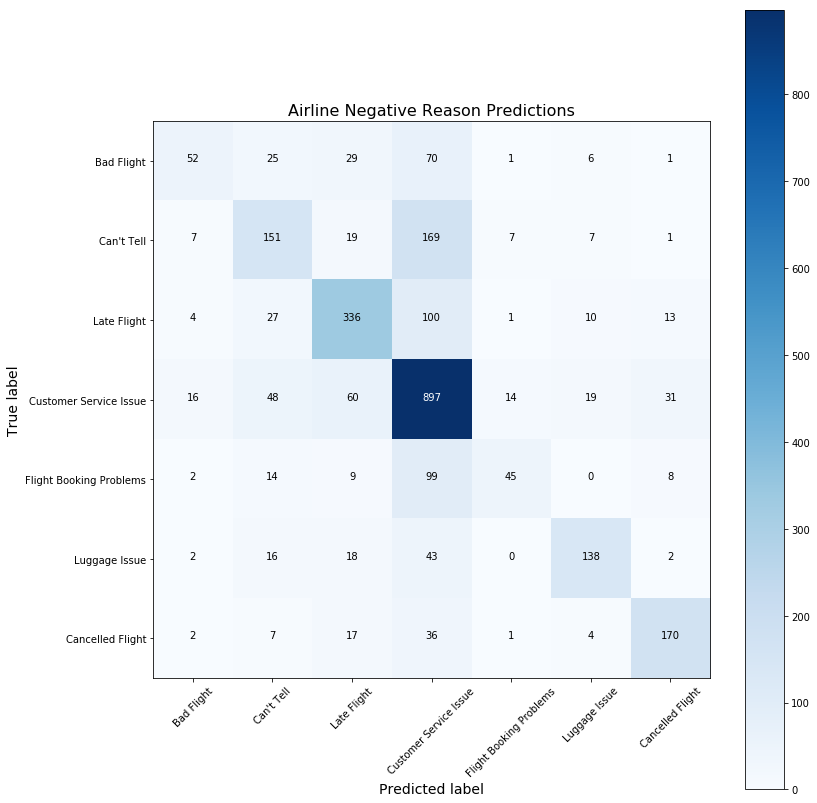

In [59]:
ticklabel=airline_tweets_neg[airline_tweets_neg.sentiment=='negative'].negative_reason.unique()
cm=metrics.confusion_matrix(Y_multi_test, y_multi_predict, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Airline Negative Reason Predictions', fs=(12,12), font_size=16)
print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores_multi.mean(), scores_multi.std() * 2))
print ('Prediction Acuracy: '+str(round(accuracy_score(Y_multi_test, y_multi_predict),3)*100)+'%')
print(classification_report(Y_multi_test,y_multi_predict))

Below are shown the incorrect predictions.

In [60]:
resultsDF = pd.DataFrame({'true':Y_multi_test,'predicted':y_multi_predict})
result_filtered=resultsDF[(resultsDF.predicted!=resultsDF.true)].reset_index()
airline_original = pd.read_csv('US_airline_tweets.csv')
for x in range (1,len(result_filtered)):
    print('Filtered: '+airline_tweets_vec.text.loc[result_filtered['index'].iloc[x]])
    print('Original: '+parse(airline_original.text.loc[result_filtered['index'].iloc[x]]))
    print('------------------------------------------------------')
    print('Predicted: '+ result_filtered.predicted.iloc[x]+'  |'+'  True: '+result_filtered.true.iloc[x])
    print('\n')

Filtered:  united update flight would great
Original: @united an update on flight 5979 would be great!
------------------------------------------------------
Predicted: Customer Service Issue  |  True: Late Flight


Filtered:  jetblue middle seat sfo bos fun keep getting credit would much rather working tv
Original: @JetBlue Only middle seats. SFO -> BOS. Not fun. She keeps getting $10 credits. Would much rather have a working TV.
------------------------------------------------------
Predicted: Customer Service Issue  |  True: Flight Booking Problems


Filtered:  americanair asked looking change flight booking problem help
Original: @AmericanAir that's not what I asked :)) I'm looking to change a Flight Booking Problems for 03.03. Can you help
------------------------------------------------------
Predicted: Customer Service Issue  |  True: Flight Booking Problems


Filtered:  usairways u bother following booked delta delta understands cust srv provided lunch delay upgraded seat
Origi

Original: @AmericanAir I do not need an apology. I need you to fix it in a competent manner.
------------------------------------------------------
Predicted: Customer Service Issue  |  True: Cancelled Flight


Filtered:  americanair sad even spending much ticket wanted wife still go sister help
Original: @AmericanAir just sad that even after spending so much on tickets all I wanted was for my wife to still go with her sister and no help
------------------------------------------------------
Predicted: Customer Service Issue  |  True: Can't Tell


Filtered:  usairways update flight orf phl one gate
Original: @USAirways any updates on flight 5202 from ORF to PHL no one at gate...  ;(
------------------------------------------------------
Predicted: Late Flight  |  True: Bad Flight


Filtered:  united hotel sent u wouldnt take voucher flight delayed cancelled flightled delayed hour counting
Original: @united the hotel you sent us to wouldnt take the voucher. Our flight was delayed, then 

Original: @united, and now while waiting for new pilot the door on plane BROKE. why am I global services status  on an airline that's unsafe? STUNNING
------------------------------------------------------
Predicted: Customer Service Issue  |  True: Bad Flight


Filtered:  united think dm would better
Original: @united I think DM would be better
------------------------------------------------------
Predicted: Customer Service Issue  |  True: Can't Tell


Filtered:  southwestair huge fan give much business please fix damn wifi
Original: @SouthwestAir I'm a huge fan and give y'all too much business...so please fix the damn wifi!
------------------------------------------------------
Predicted: Bad Flight  |  True: Can't Tell


Filtered:  jetblue trading customer experience short term sad previous loyal customer
Original: @jetblue trading customer experience for short term $$. So sad for this (previous?) loyal customer. https://t.co/dFmvmiBH4x
--------------------------------------------

------------------------------------------------------
Predicted: Can't Tell  |  True: Bad Flight


Filtered:  united monday evening
Original: @united Monday evening.
------------------------------------------------------
Predicted: Can't Tell  |  True: Luggage Issue


Filtered:  usairways usairways raleigh nc baggage carousel staff aggressive towards people waiting hr bag flight
Original: @USAirways #usairways Raleigh NC; baggage carousel staff were aggressive towards people waiting 1 1/2 hrs for bags. Flight 699
------------------------------------------------------
Predicted: Luggage Issue  |  True: Customer Service Issue


Filtered:  jetblue flight full
Original: @JetBlue Flight is 100% full.
------------------------------------------------------
Predicted: Bad Flight  |  True: Can't Tell


Filtered:  americanair nah horrible dining option outside club luckily manuel admiral make bloody mary
Original: @AmericanAir Nah, just horrible dining options outside of club. Luckily Manuel in

### Bonus: N-Grams Feature Tuning for Multi-class Prediction Model

In [61]:
n_grams=[(1,1),(1,2),(1,3),(2,2),(2,3),(3,3)]

for x in n_grams:
    
    cv_multi_n=CountVectorizer(ngram_range=(x))
    tfidf_multi_c = TfidfTransformer()

    airline_tweets_neg_text=cv_multi_n.fit_transform(airline_tweets_neg.text)
    airline_neg_trans = tfidf_multi_c.fit_transform(airline_tweets_neg_text)
    X_multi=airline_neg_trans
    Y_multi=airline_tweets_neg[airline_tweets_neg.sentiment=='negative'].negative_reason

    X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = train_test_split(X_multi,Y_multi,test_size=0.3, random_state=101)
    model_multi_n_grams = LogisticRegression()
    model_multi_n_grams.fit(X_multi_train, Y_multi_train)
    y_multi_predict_n = model_multi_n_grams.predict(X_multi_test)
    print ('Accuracy Score: '+ str(round(accuracy_score(Y_multi_test, y_multi_predict_n),3))+' N='+str(x))

/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy Score: 0.633 N=(1, 1)
Accuracy Score: 0.587 N=(1, 2)
Accuracy Score: 0.555 N=(1, 3)
Accuracy Score: 0.479 N=(2, 2)
Accuracy Score: 0.446 N=(2, 3)
Accuracy Score: 0.411 N=(3, 3)


As seen above, accuracy of this multi-classification model is the highest with unigrams.

### Bonus: Multi-Class Logistic Regression Hyper Parameter Tuning: C parameter

In [62]:
C_param_range=list(np.arange(2, 3, 0.1))
accuracy_multi=[]
for x in C_param_range:
    
    cv_multi_c=CountVectorizer(ngram_range=(1,1))
    tfidf_multi_c = TfidfTransformer()

    airline_tweets_neg_text=cv_multi_c.fit_transform(airline_tweets_neg.text)
    airline_neg_trans = tfidf_multi_c.fit_transform(airline_tweets_neg_text)
    X_multi=airline_neg_trans
    Y_multi=airline_tweets_neg[airline_tweets_neg.sentiment=='negative'].negative_reason

    X_multi_train, X_multi_test, Y_multi_train, Y_multi_test = train_test_split(X_multi,Y_multi,test_size=0.3, random_state=101)
    model_multi_c = LogisticRegression(C=x)
    model_multi_c.fit(X_multi_train, Y_multi_train)
    y_multi_predict_c = model_multi_c.predict(X_multi_test)
    print ('Accuracy Score: '+ str(round(accuracy_score(Y_multi_test, y_multi_predict_c),3))+' C='+str(x))
    accuracy_multi.append(round(accuracy_score(Y_multi_test, y_multi_predict_c),3))

/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy Score: 0.649 C=2.0
Accuracy Score: 0.649 C=2.1
Accuracy Score: 0.649 C=2.2
Accuracy Score: 0.649 C=2.3000000000000003
Accuracy Score: 0.649 C=2.4000000000000004
Accuracy Score: 0.65 C=2.5000000000000004
Accuracy Score: 0.65 C=2.6000000000000005
Accuracy Score: 0.65 C=2.7000000000000006
Accuracy Score: 0.649 C=2.8000000000000007
Accuracy Score: 0.649 C=2.900000000000001


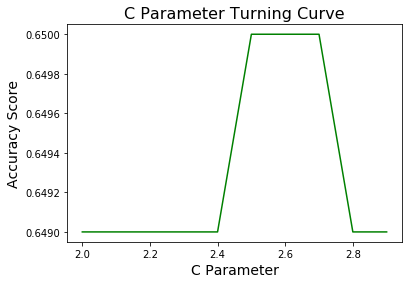

In [63]:
test_set,=plt.plot(C_param_range, accuracy_multi, color='green')
plt.title('C Parameter Turning Curve', fontsize=16)
plt.xlabel('C Parameter',fontsize=14)
plt.ylabel('Accuracy Score',fontsize=14)
plt.show()

The Highest accuracy score on the C parameter is 65%, at around C=2.5. Thus C=2.5 is choosen for the logistic regression model.

## 5. Discussions

### 5.1 What can public opinion on Twitter tell us about the US airlines in 2015?

#### Answer

Airline Tweet Prediction Result Summary


predictions,negative,positive,%neg,%pos,total
airline,,,,,
united,2173,951,69.6,30.4,3124
usairways,1866,666,73.7,26.3,2532
americanair,1625,671,70.8,29.2,2296
southwestair,1077,680,61.3,38.7,1757
jetblue,730,766,48.8,51.2,1496
virginamerica,167,166,50.2,49.8,333
deltaassist,1,1,50.0,50.0,2


Airline Tweet Sentiment Prediction Report

              precision    recall  f1-score   support

    negative       0.96      0.80      0.87      9178
    positive       0.52      0.86      0.65      2362

   micro avg       0.81      0.81      0.81     11540
   macro avg       0.74      0.83      0.76     11540
weighted avg       0.87      0.81      0.82     11540



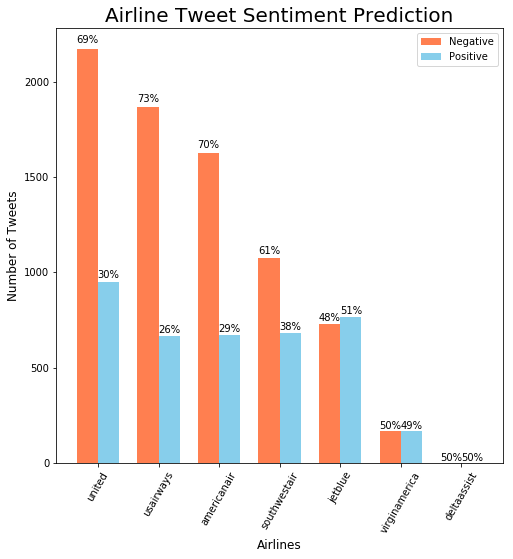

In [64]:
tmp = {'airline': airline_tweets_vec.airline, 'predictions': y_pred_air, 'dummy':'1'}
airline_predicted = pd.DataFrame(data=tmp)
tmp = pd.pivot_table(airline_predicted, values='dummy', index=['airline'], columns=['predictions'], aggfunc='count')
tmp['%neg']=tmp.apply(lambda x: round(int(x['negative'])/(int(x['positive'])+int(x['negative'])),3)*100,axis=1)
tmp['%pos']=tmp.apply(lambda x: round(int(x['positive'])/(int(x['positive'])+int(x['negative'])),3)*100,axis=1)
tmp['total']=tmp.apply(lambda x: (int(x['positive'])+int(x['negative'])),axis=1)
tmp=tmp.sort_values(by=['total'], ascending=False)

print('Airline Tweet Prediction Result Summary')
display(tmp)

print('Airline Tweet Sentiment Prediction Report\n')
print(classification_report(airline_tweets_vec.sentiment, y_pred_air))

neg = tmp['negative'].values

fig, ax = plt.subplots()

ind = np.arange(len(tmp))    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind,neg, width, color='coral')

pos = tmp['positive'].values

p2 = ax.bar(ind + width, pos, width, color='skyblue')

ax.set_title('Airline Tweet Sentiment Prediction', fontsize=20)
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(list(tmp.index.values), rotation=60)

ax.legend((p1[0], p2[0]), ('Negative', 'Positive'))
ax.autoscale_view()
plt.xlabel('Airlines', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
fig.set_size_inches(8,8)

i=0
for rect in p1:
    height = rect.get_height()
    value = round(tmp['%neg'][i],3)
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
            '%d' % int(value) + "%", ha='center', va='bottom')
    i+=1

i=0
for rect in p2:
    height = rect.get_height()
    value = round(tmp['%pos'] [i],3)
    ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,
            '%d' % int(value) + "%", ha='center', va='bottom')
    i+=1

plt.show()

Based on this data set, the prediction result shows that majority of the public opinion on US Airline on Twitter is negative. 

The following are listed in the order of most to least number of negative tweets.
1. **United Airlines** have highest number of negative tweets, at 2173 number of negative tweets, which is 69.6% of total tweets mentioning it. The public opinion on United Airlines is a negative one.
2. **US Airways** has the most negative percentage of tweets. Of 2532 number of tweets mentioning it, 73.7% of which are negative. The public opinion on US Airways is a negative one.
3. **American Air** has the second highest negative percentage of tweets, 70.8% of its 2296 tweets are negative. The public opinion on American Air is a negative one.
4. **Southwest Air** is have 61.3% of its 1757 tweets being negative. The public opinion on Southwest Air is a negative one, however it is better compared to the first 3.
5. **Jet Blue and Virgin America** have about equal amount of negative and positive tweets mentioning them. This data shows that the public opinion on these two airelines is neutral.
6. No definitive conclusion can be drawn for **DeltaAssist**, as it has only 2 tweets about it.

One source of bias in this analysis is that this source of the data is from people who voluntarily posted on social media. It could be that people are more likely to voice their complaints on social media than extentending their appreation to the airline companies. The ones who are posting could be a vocal minority. 

This model has a large discrepency between the precision scores. This is likely due to there are more number of negative tweets in the prediction set, which means that there were more number of negative tweets which was predicted as positive tweets, thus lowering the positive precision score. This is shown below by feeding the same number of positive and negative tweets into the prediction model. This result did not have the large discrepency.

In [65]:
tmp=airline_tweets_vec[airline_tweets_vec.sentiment=='negative'].iloc[0:2362]
tmp2=airline_tweets_vec[airline_tweets_vec.sentiment=='positive']
tmp2=tmp2.append(tmp, ignore_index=True)
tmp3=cv.transform(tmp2.text)
tmp4 = tfidf.transform(tmp3)
tmp5=model.predict(tmp4)
print(classification_report(tmp2.sentiment, tmp5))

              precision    recall  f1-score   support

    negative       0.85      0.79      0.82      2362
    positive       0.80      0.86      0.83      2362

   micro avg       0.83      0.83      0.83      4724
   macro avg       0.83      0.83      0.82      4724
weighted avg       0.83      0.83      0.82      4724



#### Suggested Improvements

1. The typos and informal lauguage adds noise to the data. These could be improved by applying spell correction to each text in the dataset, which would help eliminate words with extremely low frequency. This was improvement was previously attemped with the [python autocorrect library](https://pypi.org/project/autocorrect/) however was abondaned due to very high computational cost.


2. Emoticons are what people on social media typically use to express sentiment. These might carry higher sentiment value in than words in the analysis. However, they were removed in the data cleaning process. Including these as part of the analysis might improve performance of the model. 


3. The model could be trained with domain specific dataset rather than a generic dataset to improve the model prediction in that domain. This idea is tested out in the code below, training the logistic regression model using the US Airline tweets. Which gave a prediction accuracy of 90.4% without parameter tuning and N-grams tuning.

Airline Tweet Trained Model Test Accuracy: 90.4%

              precision    recall  f1-score   support

    negative       0.90      0.99      0.94      2785
    positive       0.92      0.56      0.69       677

   micro avg       0.90      0.90      0.90      3462
   macro avg       0.91      0.77      0.82      3462
weighted avg       0.90      0.90      0.89      3462



/home/richard/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<Figure size 432x288 with 0 Axes>

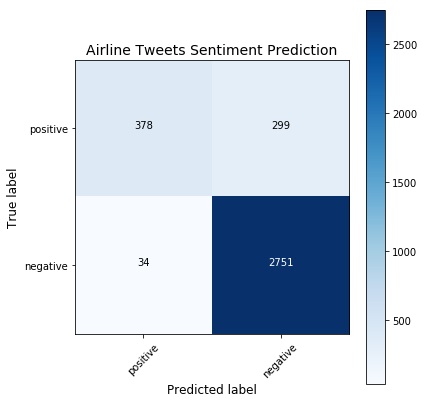

In [66]:
model_air=LogisticRegression()
cv_air=CountVectorizer()
airline_bag=cv_air.fit_transform(airline_tweets_vec.text)
airline_fit = TfidfTransformer().fit(airline_bag)
airline_trans = airline_fit.transform(airline_bag)
airline_trans.shape

X_air=airline_trans
Y_air=airline_tweets_vec['sentiment']

X_train_air, X_test_air, Y_train_air, Y_test_air=train_test_split(X_air,Y_air,test_size=0.3, random_state=100)

model_air.fit(X_train_air,Y_train_air)

y_pred_air_2=model_air.predict(X_test_air)

ticklabel=airline_tweets_vec.sentiment.unique()
cm=metrics.confusion_matrix(Y_test_air, y_pred_air_2, labels=ticklabel)
plt.figure()
plot_confusion_matrix(cm, classes=ticklabel, title='Airline Tweets Sentiment Prediction', fs=(6,6), font_size=14)
print ('Airline Tweet Trained Model Test Accuracy: '+str(round(accuracy_score(Y_test_air, y_pred_air_2),3)*100)+'%'+'\n')
print(classification_report(Y_test_air, y_pred_air_2))

### 5.2 Why are did the multi-classification model fail to predict the correct negative reasons?

#### Answer

In [67]:
print('Percentage of Each Class of Airline Negative Reasons'+'\n')
print(airline_tweets_neg.negative_reason.value_counts())
print('\n')
print('Airline Negative Reason Prediction Summary')
print ('Model Accuracy: '+str(round(accuracy_score(Y_multi_test, y_multi_predict),3)*100)+'%')
print(classification_report(Y_multi_test,y_multi_predict))

Percentage of Each Class of Airline Negative Reasons

Customer Service Issue     3569
Late Flight                1665
Can't Tell                 1190
Cancelled Flight            847
Luggage Issue               798
Bad Flight                  580
Flight Booking Problems     529
Name: negative_reason, dtype: int64


Airline Negative Reason Prediction Summary
Model Accuracy: 65.0%
                         precision    recall  f1-score   support

             Bad Flight       0.61      0.28      0.39       184
             Can't Tell       0.52      0.42      0.47       361
       Cancelled Flight       0.75      0.72      0.73       237
 Customer Service Issue       0.63      0.83      0.72      1085
Flight Booking Problems       0.65      0.25      0.37       177
            Late Flight       0.69      0.68      0.69       491
          Luggage Issue       0.75      0.63      0.68       219

              micro avg       0.65      0.65      0.65      2754
              macro avg       0.

The model fails to predict the correct negative reasons because there isn't enough data for some of the categories. This is as evident by the table above, showing that *Customer Service Issue*, has 3569 samples, 39% of the data set. The next category, *Late Flight*, only has 1665 samples, 18% of the dataset. The smallest category size, *Flight Booking Problems* only have 529 samples, 6% of the dataset. This means that there might not be enough patters for the class with small sample size for the model to identify the pattern for that issue.

This is also evident in the recall scores, the percentage of correctly identification when given that class. If ranking the recal score from lowest to highest, the ranking roughly matches with the number of tweets for each class with the exception of *Can't Tell* class. This class are the tweets that the data collector wasn't able to identify.

#### Suggested Improvement

1. This model could be improved with more data for each class. With increasing number of training data for the class that currently have very little, the model could perform better.

2. Remove the *Can't Tell* class from the training model. This is because the data collector identified that these tweets does not have a patter that would associate it with a specific class, thus it was grouped into the *Can't Tell* class. Having this class as part of the training model means that the model could also have difficulty finding a pattern for this class. Though this could be alleviated with more data.